In [1]:
import pickle
from datetime import datetime
from dateutil.tz import tzoffset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch import optim
from scipy.stats import kendalltau, spearmanr
from sklearn.preprocessing import OneHotEncoder

# Задача 1

Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
- взять в тренировочный набор турниры с dateStart из 2019 года; 
- в тестовый — турниры с dateStart из 2020 года.

In [2]:
with open("players.pkl", "rb") as fio:
    players = pickle.load(fio)

In [3]:
with open("results.pkl", "rb") as fio:
    results = pickle.load(fio)

In [4]:
with open("tournaments.pkl", "rb") as fio:
    tournaments = pickle.load(fio)

In [5]:
dateformat = "%Y-%m-%dT%H:%M:%S%z"

Загрузим данные и разделим на тренировочный и тестовый датасет

In [6]:
train_data =  []
test_data = []

for key, value in results.items():
    for team in value:
        for team_member in team["teamMembers"]:
            tournament_year = datetime.strptime(tournaments[key]["dateStart"], dateformat).year
            if team.get("mask", None) and tournament_year == 2019:
                train_data.append({
                    "tournament_id": key,
                    "tournament_name": tournaments.get(key).get("name"),
                    "team_id": team["team"]["id"],
                    "team_name": team["team"]["name"],
                    "questions_mask": team.get("mask", None),
                    "questionQty": tournaments.get(key).get("questionQty"),
                    "position": team.get("position", None),
                    "player_id": team_member["player"]["id"],
                    "player_name": team_member["player"]["surname"] + " " + \
                                   team_member["player"]["name"] + " " + \
                                   team_member["player"]["patronymic"]
                })
            elif team.get("mask", None) and tournament_year == 2020:
                test_data.append({
                    "tournament_id": key,
                    "tournament_name": tournaments.get(key).get("name"),
                    "team_id": team["team"]["id"],
                    "team_name": team["team"]["name"],
                    "position": team.get("position", None),
                    "player_id": team_member["player"]["id"],
                    "player_name": team_member["player"]["surname"] + " " + \
                                   team_member["player"]["name"] + " " + \
                                   team_member["player"]["patronymic"]
                })

In [7]:
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [8]:
del results

оставим только те команды у которых длинна ответов равна количеству вопросов

In [9]:
train_data["questionQty"] = train_data["questionQty"].apply(lambda x: sum(list(x.values())))

In [10]:
train_data[train_data["questions_mask"].apply(len) != train_data["questionQty"]]["tournament_id"].nunique()

12

In [11]:
train_data = train_data[train_data["questions_mask"].apply(len) == train_data["questionQty"]].copy()

посмотрим распределение числа игроков по командам

C:\Users\anton.nesterenko\Miniconda3\envs\made_advance\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


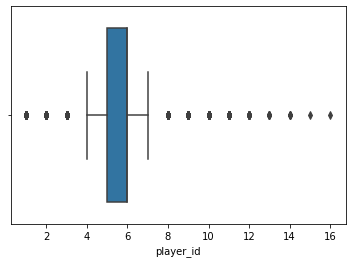

In [12]:
sns.boxplot(train_data.groupby(["team_id", "tournament_id"])["player_id"].nunique());

посмотрим на итоговый размер данных и количество турниров

In [13]:
train_data.shape[0], test_data.shape[0]

(414743, 112841)

In [14]:
train_data["tournament_id"].nunique(), test_data["tournament_id"].nunique()

(675, 173)

# Задача 2

Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков.

- повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
- в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
- для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.

Преобразуем тренировочные данные в повопросные результаты по игрокам, в качестве id вопроса будем использовать id турнира и порядковый номер вопроса

In [15]:
question_answer_data = {
    "question": [],
    "player": [],
    "initial_label": [],
    "team_id": [],
    "tournament_id": []
}
for tour_id, team_id, player_id, mask in zip(train_data["tournament_id"], train_data["team_id"], train_data["player_id"], train_data["questions_mask"]):
    for i, result in enumerate(mask):
        if result != "X" and result != "?":
            question_answer_data["tournament_id"].append(tour_id)
            question_answer_data["team_id"].append(team_id)
            question_answer_data["question"].append(f"{tour_id}_{i}")
            question_answer_data["player"].append(player_id)
            question_answer_data["initial_label"].append(int(result))

In [16]:
question_answer_data = pd.DataFrame(question_answer_data)

In [17]:
question_answer_data["player"] = question_answer_data["player"].astype(np.int32)
question_answer_data["team_id"] = question_answer_data["team_id"].astype(np.int32)
question_answer_data["tournament_id"] = question_answer_data["tournament_id"].astype(np.int32)
question_answer_data["question"] = question_answer_data["question"]
question_answer_data["initial_label"] = question_answer_data["initial_label"].astype(np.uint8)

закодируем id игроков и вопросов в OHE представление

In [18]:
encoder = OneHotEncoder()

train_data = encoder.fit_transform(question_answer_data[["player", "question"]])

Введем вспомогательные функции для нашей логистической регрессии

- sigmoid - сигмойда над линейной комбинацией признаков и весов
- cost_function - среднее логарифмическое правдоподобие
- gradient - градиент dL/dw на текущей итерации
- fit функция тренировки модели

In [19]:
class LogisticRegression(nn.Module):
    
    def __init__(self, n_features):
        
        super().__init__()
        self.fc = nn.Linear(n_features, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        return self.sigmoid(self.fc(x))

In [20]:
def m_step(model, x, y, lr=1e-4, n_iter=50):
    
    model.fc.reset_parameters()
    criteria = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr)
    for i in range(n_iter):

        optimizer.zero_grad()
        output = model(x)
        loss = criteria(output, y)
        loss.backward()
        optimizer.step()

введем функцию которая будет брать топ 20 игроков по силе игрока полученной из модели

In [21]:
def get_top_players(parameters, n=20):
    player_weights = {}
    for i, c in enumerate(encoder.get_feature_names()):
        if c.startswith("x0_"):
            player_weights[int(c[3:])] = parameters[i]
    top_players = sorted([(k, v) for k, v in player_weights.items()], reverse=True, key=lambda x: x[1])[:n]
    top_players = [
        players[i]["surname"] + " " + 
        players[i]["name"] + " " + 
        players[i]["patronymic"] + " " + str(i) 
        for i, _ in top_players
    ]
    return top_players

Обучим модель предсказывать ответил ли игрок i на вопрос j

Для начала воспользуемся простым предположением - если команда ответила на вопрос то тогда каждый из игроков ответил на вопрос

Если команда не ответила на вопрос то каждый из игроков не ответил на него

Тогда:

$$\large{\sigma(p_i + q_j + \mu) = p(z=1) = p(t=1)}$$

Метки для p(t = 1) у нас есть в данных

In [22]:
train_data = train_data.tocoo()

x = torch.sparse.FloatTensor(
    torch.LongTensor(np.vstack((train_data.row, train_data.col))),
    torch.FloatTensor(train_data.data)
)

y = torch.FloatTensor(question_answer_data["initial_label"].values).view(-1, 1)

model = LogisticRegression(x.shape[1])

In [23]:
%%time
m_step(model, x, y, lr=1, n_iter=100)

Wall time: 4min 12s


# Задача 3

Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
- предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
- в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.


функция для подсчета метрик на тестовом датасете

силу команды будем трактовать как вероятность того что хотя бы один игрок из команды ответит на средний вопрос

$$\large{team_i = 1 - \prod_{j = 1}^{N}(1 - \sigma(p_{ij} + q_{mean} + \mu))}$$

Где:
- $p_{ij}$ - сила игрока j в команде i
- N - количество игроков в команде i
- $q_{mean}$ - средний вопрос
- $\mu$ - глобальная константа

In [24]:
def calc_metrics(data, encoder, parameters, intercept):
    player_weights = {}
    count = 0
    question_sum = 0
    player_sum = 0
    player_cnt = 0
    for i, c in enumerate(encoder.get_feature_names()):
        if c.startswith("x0_"):
            player_weights[int(c[3:])] = parameters[i]
            player_sum += parameters[i]
            player_cnt += 1
        else:
            question_sum += parameters[i]
            count += 1
    question_mean = question_sum / count
    data["player_weights"] = data["player_id"].map(player_weights)
    data["player_weights"].fillna(player_sum / player_cnt, inplace=True)
    data["players_proba"] = data["player_weights"].apply(lambda x: 1 / (1 + np.exp(-(x + question_mean + intercept))))
    probas = data.groupby(["tournament_id", "team_id"])["players_proba"].apply(lambda x: np.prod(1 - x))
    position = data.groupby(["tournament_id", "team_id"])["position"].first()
    group_data = pd.concat([probas, position], axis=1)
    group_data.sort_values(["tournament_id", "players_proba"], ascending=[True, True], inplace=True)
    spear = group_data.groupby("tournament_id").apply(lambda x: spearmanr(x["position"], x["players_proba"]).correlation).mean()
    kendl = group_data.groupby("tournament_id").apply(lambda x: kendalltau(x["position"], x["players_proba"]).correlation).mean()
    print(f"spearman: {spear}")
    print(f"kendl: {kendl}")

In [25]:
calc_metrics(test_data, encoder, model.fc.weight.data[0].numpy(), model.fc.bias.data[0].numpy())

spearman: 0.7860040917333996
kendl: 0.6291184034860392


In [26]:
get_top_players(model.fc.weight.data[0].numpy(), 20)

['Руссо Максим Михайлович 27403',
 'Брутер Александра Владимировна 4270',
 'Семушин Иван Николаевич 28751',
 'Савченков Михаил Владимирович 27822',
 'Спешков Сергей Леонидович 30270',
 'Сорожкин Артём Сергеевич 30152',
 'Кудинов Дмитрий Сергеевич 40411',
 'Пилипенко Максим Игоревич 38175',
 'Мереминский Станислав Григорьевич 20691',
 'Подюкова Валентина  202410',
 'Левандовский Михаил Ильич 18036',
 'Николенко Сергей Игоревич 22799',
 'Прокофьева Ирина Сергеевна 26089',
 'Новиков Илья Сергеевич 22935',
 'Царёв Михаил Сергеевич 34328',
 'Ишин Вадим Александрович 12785',
 'Саксонов Антон Владимирович 87637',
 'Либер Александр Витальевич 18332',
 'Мосягин Александр Владимирович 21698',
 'Мокин Игорь Викторович 74001']

# Задача 4

Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
- предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
- разработайте EM-схему для обучения этой модели, реализуйте её в коде;
- обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.


Воспользуемся простыми предположениями:

1. Если один из игроков ответил на вопрос то тогда команда ответила на вопрос
2. Если команда не ответила на вопрос, то все игроки не ответили на него
3. Игроки отвечают на вопрос независимо

Тогда будем моделировать

$$\large{p(z_{ij}=1|t_{i}=y)}$$

Очевидно что:

$$\large{p(z_{ij}=1|t_{i}=0) = 0}$$

Осталось посчитать:

$$\large{p(z_{ij}=1|t_{i}=1) = \frac{p(t_{i}=1|z_{ij}=1)p(z_{ij}=1)}{p(t_{i}=1)}}$$

- $\large{p(t=1|z=1) = 1}$ по нашему второму предположению
- $\large{p(z=1) = \sigma(p_i + q_j + \mu)}$ - возьмем предсказание из модели полученной на М-шаге
- $\large{p(t_{i}=1) = 1 - \prod_{k=1}^{N}(1 - \sigma(p_{ik} + q_j + \mu))}$ - вероятность команды ответить на вопрос это 1 - вероятность что все игроки не ответили на него

Тогда:

$$\large{p(z_{ij}=1|t_{i}=1) = \frac{\sigma(p_i + q_j + \mu)}{1 - \prod_{k=1}^{N}(1 - \sigma(p_{ik} + q_j + \mu))}}$$

Это и будет нашим Е-шагом

In [27]:
def e_step(data, predicts):
    data["label"] = predicts
    data.loc[data["initial_label"] == 0, "label"] = 0
    idx = data["initial_label"] == 1
    sp = data.loc[idx].groupby(["team_id", "question"])["label"].transform(lambda x: 1 - np.prod(1 - x.values))
    data.loc[idx, "label"] = data.loc[idx, "label"] / sp  
    return data

In [28]:
predicts = model(x).detach().numpy().ravel()
for i in range(10):
    question_answer_data = e_step(question_answer_data, predicts)
    y = torch.FloatTensor(question_answer_data["label"].values).view(-1, 1)
    m_step(model, x, y, lr=1, n_iter=100)
    torch.save(model.state_dict(), f"model_{i}.pth")
    predicts = model(x).detach().numpy().ravel()
    print(f"Iter: {i}")
    calc_metrics(test_data, encoder, model.fc.weight.data[0].numpy(), model.fc.bias.data[0].numpy())

Iter: 0
spearman: 0.7939394041873525
kendl: 0.6383232634540364
Iter: 1
spearman: 0.7939665757368832
kendl: 0.6381125072312274
Iter: 2
spearman: 0.7968185546008305
kendl: 0.6403856883440304
Iter: 3
spearman: 0.7972532645937495
kendl: 0.641105593219204
Iter: 4
spearman: 0.7998877081185888
kendl: 0.6449342819026225
Iter: 5
spearman: 0.8014145572728014
kendl: 0.6466035490118153
Iter: 6
spearman: 0.8013198796683845
kendl: 0.6463252524801003
Iter: 7
spearman: 0.8012457181066227
kendl: 0.6460572625998251
Iter: 8
spearman: 0.8012021985723302
kendl: 0.6458258261780518
Iter: 9
spearman: 0.8015102957769751
kendl: 0.6462851634075643


# Задача 5

А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).

Для простоты будем считать что сложность турнира это средняя сложность вопросов в нем

In [29]:
parameters = model.fc.weight.data[0].numpy()

question_weights = {}
for i, c in enumerate(encoder.get_feature_names()):
    if c.startswith("x1_"):
        question_weights[c[3:]] = parameters[i]

In [30]:
tournament_weights = question_answer_data.groupby("tournament_id")["question"].apply(lambda x: np.mean([question_weights[q] for q in x])).sort_values()

In [31]:
tournament_weights.reset_index()["tournament_id"].apply(lambda x: tournaments[x]["name"]).head(20)

0               Чемпионат Санкт-Петербурга. Первая лига
1                                Чемпионат Таджикистана
2                                           Угрюмый Ёрш
3                Зеркало мемориала памяти Михаила Басса
4                            Синхрон высшей лиги Москвы
5                                    Воображаемый музей
6                          Первенство правого полушария
7                       Чемпионат Мира. Этап 2 Группа С
8                      Чемпионат Мира. Этап 2. Группа В
9     Седьмая октава: Кубок Равноденствия. Лига Наци...
10                     Чемпионат Мира. Этап 3. Группа С
11                                               День D
12                        Мемориал памяти Михаила Басса
13                                     Записки охотника
14              Чемпионат Санкт-Петербурга. Высшая лига
15                     Чемпионат Мира. Этап 1. Группа С
16                                     Знание – Сила VI
17                                     Чемпионат

In [32]:
tournament_weights.reset_index()["tournament_id"].apply(lambda x: tournaments[x]["name"]).tail(20)

655                    Школьный Синхрон-lite. Выпуск 3.1
656                 Межфакультетский кубок МГУ. Отбор №4
657              (а)Синхрон-lite. Лига старта. Эпизод IX
658                                     Кубок Тышкевичей
659                                        Школьная лига
660                               Школьная лига. II тур.
661                    Школьный Синхрон-lite. Выпуск 2.5
662    Олимпиада Приволжского федерального округа. Финал
663               (а)Синхрон-lite. Лига старта. Эпизод V
664     Второй тематический турнир имени Джоуи Триббиани
665                                          Чёрная Быль
666                                Школьная лига. I тур.
667                              Школьная лига. III тур.
668       Студенческий чемпионат Калининградской области
669                                     Кубок Закарпатья
670                                     One ring - async
671                       Гран-при Славянки. Общий зачёт
672                            

In [33]:
top_20_players = get_top_players(parameters, 20)

In [34]:
top_20_players

['Пилипенко Максим Игоревич 38175',
 'Немец Илья Сергеевич 22474',
 'Козлова Ольга Александровна 14996',
 'Бровченко Елена Борисовна 199963',
 'Подюкова Валентина  202410',
 'Кудинов Дмитрий Сергеевич 40411',
 'Голудина Мария Юрьевна 188876',
 'Фрайман Феликс  33459',
 'Лазарева Галина Вячеславовна 17750',
 'Иоаннидис Андриан  199113',
 'Луконин Дмитрий  199114',
 'Королихин Анатолий  199115',
 'Петров Игорь  199112',
 'Петров Роман  199111',
 'Войцеховская Станислава Валерьевна 5805',
 'Спектор Евгений Павлович 30260',
 'Прохоров Константин  196901',
 'Ишин Вадим Александрович 12785',
 'Шобанов Андрей  132330',
 'Царёв Михаил Сергеевич 34328']

In [36]:
top_20_players_id = [int(v.split(" ")[-1] for in top_20_players]

ValueError: too many values to unpack (expected 2)

In [ ]:
question_answer_data[question_answer_data["player"].isin(set(top_20_players))].groupby("player")["tournament_id"].nunique()